# Replication of a Hate speech detection methodology applied to portuguese

This notebook aims to share the work done on replicating the methodology presented in Davidson et al. 2017, "Automated Hate Speech Detection and the Problem of Offensive Language" and apply it to the portuguese corpora introduced in Fortuna2017, "Automatic detection of hate speech in text: an overview of the topic and dataset annotation with hierarchical classes".

In [1]:
from classifier import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline


## Loading the data

In [2]:
df = load_dataset('dataset/dataset_dummy_classes.csv')

The methodology presented in Davidson et al. aims to automatically identify hate speech, offensive language or neither of the previous. We replicate this approach on a portuguese corpora but only considering hate speech and not hate speech. Both datasets are composed by text spans (tweets) from the twitter platform.

In [5]:
df.describe()

,tweet_id,Hate.speech
count,5.668000e+03,5668.000000
mean,7.488717e+17,0.216655
std,2.223222e+17,0.412002
min,6.061792e+09,0.000000
25%,8.218489e+17,0.000000
50%,8.367213e+17,0.000000
75%,8.393120e+17,0.000000
max,8.398362e+17,1.000000


In [6]:
df.columns


Index(['tweet_id', 'text', 'Hate.speech'], dtype='object')

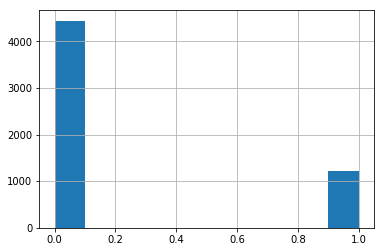

In [7]:
df['Hate.speech'].hist()

Both datasets are very unbalenced being the class containing hate speech the minority one. This dataset has aproximately a 1:4 ratio and the one used in Davidson et al. has aproximately a 1:10 ratio considering only 'hate speech' class vs 'no hate'.

In [1]:
tweets = df['text']

NameError: name 'df' is not defined

## Feature generation

This section describes the feature generation process. The feature groups used were: tfidf (term frequency/inverse document frequency), pos (part-of-speech) tags counts, and a group of features containing statistics, readability metrics, twitter objects (i.e. hashtags, urls and mentions) counts and sentiment score.
Since we are targeting a different language we could not relly on the exact same methods/resources used in the original approach and therefor certain modifications had to be introduced.
Summarizing, we needed to use portuguese versions of stopwords, lemmatizer, pos-tagger and sentiment.

In [9]:
import nltk
from classifier import preprocess
from classifier import tokenize
from classifier import basic_tokenize
from classifier import get_pos_tags
from sklearn.feature_extraction.text import TfidfVectorizer


In [10]:
#tfidf features were obtained filtering 'stopwords', for that purpose we rellied on nltk has it 
#contains a list of stopwords for portuguese
stopwords = nltk.corpus.stopwords.words("portuguese")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)



In [11]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75,
)


In [12]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores



In [13]:
# for extracting pos tags we used 'spacy' library because it contains a pos tagger trained on 
#portuguese news corpora and reports a 78% acuracy.   
import pt_core_news_sm
#Get POS tags for tweets and save as a string
tweet_tags = []
nlp = pt_core_news_sm.load()
for t in tweets:
    clean = preprocess(t)
    doc = nlp(clean)
    tags = [w.pos_ for w in doc]
    tag_str = " ".join(tags)
    tweet_tags.append(tag_str)

In [14]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [15]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}


In [16]:
#For this feature group, we maintaned all features intact but the sentiment feature. 
# For this one we had to replace the sentiment library used 'vader' and its 4 features 
#(neutral, positive, negative and compound) for a sentiment score (aggregate sum) obtained 
#using sentilex-pt
from classifier import count_twitter_objs
from classifier import OtherTransformer
from classifier import other_features


other = OtherTransformer()
other_features = other.fit_transform(tweets)
other_features_names = other.get_feature_names()

In [17]:
#Now join them all up
M = np.concatenate([tfidf,pos,other_features],axis=1)

In [18]:
M.shape

(5668, 4312)

In [19]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names


## Model generation

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report



In [21]:
X = pd.DataFrame(M)
y = df['Hate.speech'].astype(int)

In [22]:
# dimensionality reduction
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(X,y)

In [23]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge').fit(X_, y)

In [24]:
y_preds = model.predict(X_)

In [25]:
report = classification_report( y, y_preds )

In [26]:
print(report)

             precision    recall  f1-score   support

          0       0.92      0.89      0.90      4440
          1       0.65      0.71      0.68      1228

avg / total       0.86      0.85      0.86      5668



Test Accuracy= 0.8532110091743119


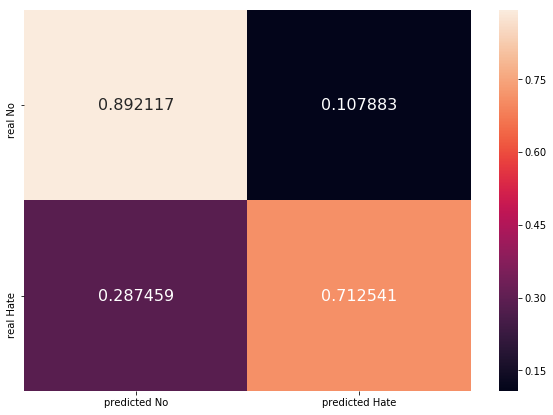

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
%matplotlib inline

datasetAccuracy = np.mean(y_preds == y)
print("Test Accuracy= " + str(datasetAccuracy))
confusion_matrix = confusion_matrix(y,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
    
confusion_df = pd.DataFrame(matrix_proportions, index=['real No', 'real Hate'], columns=['predicted No', 'predicted Hate'])
plt.figure(figsize=(10, 7))
sn.heatmap(confusion_df, annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()
#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')





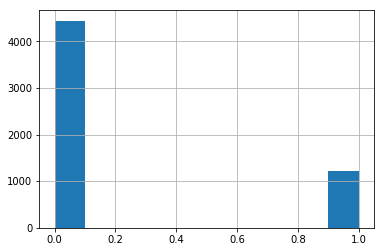

In [28]:
#True distribution
y.hist()

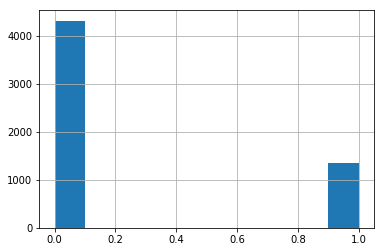

In [29]:
#Predictions distribution
pd.Series(y_preds).hist()


## Conclusions

Comparing the performance of both models for average f1-score (pt-0,86 en-0,90) we notice that the overall results are worst but not significantly and we report a significant improve on the hate class detection (pt-precision:0,65 pt-recall:0,71 vs  en-precision:0,4 en-recall:0,61 ). Even that the task configurations differ and the corpus language is different, we can say that this approach seems to work in the portuguese language. Further enhancements could pass by improving language specific methods used thought out the approach.   